# Tesseract OCR


Tesseract is an open source text recognition (OCR) Engine, available under the Apache 2.0 license. It can be used directly, or (for programmers) using an API to extract printed text from images. It supports a wide variety of languages. Tesseract doesn't have a built-in GUI, but there are several available from the 3rdParty page. Tesseract is compatible with many programming languages and frameworks through wrappers that can be found here. It can be used with the existing layout analysis to recognize text within a large document, or it can be used in conjunction with an external text detector to recognize text from an image of a single text line.

<img src = 'https://nanonets.com/blog/content/images/2019/11/ocr_flow.png'></img>

## Imports

In [39]:
import re
import cv2 
import numpy as np
import pytesseract
from pytesseract import Output
from matplotlib import pyplot as plt
from PIL import Image

In [10]:
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

## Load Image

In [11]:
img = 'imgs/invoice-input.png'

## Preprocessing

In [12]:
# get grayscale image
def get_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# noise removal
def remove_noise(image):
    return cv2.medianBlur(image,5)
 
#thresholding
def thresholding(image):
    return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

#dilation
def dilate(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.dilate(image, kernel, iterations = 1)
    
#erosion
def erode(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.erode(image, kernel, iterations = 1)

#opening - erosion followed by dilation
def opening(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

#canny edge detection
def canny(image):
    return cv2.Canny(image, 100, 200)

#skew correction
def deskew(image):
    coords = np.column_stack(np.where(image > 0))
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return rotated

#template matching
def match_template(image, template):
    return cv2.matchTemplate(image, template, cv2.TM_CCOEFF_NORMED) 

### Before Preprocessing

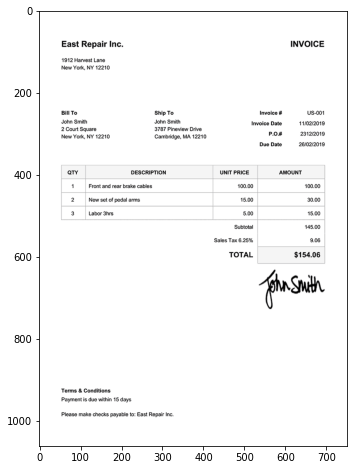

In [13]:
# read image
image = cv2.imread(img)
# change dimensions
plt.figure(figsize=(10, 8))
# display
plt.imshow(image)

### After Preprocessing

In [14]:
# preprocess
gray = get_grayscale(image)
thresh = thresholding(gray)
opening = opening(gray)
canny = canny(gray)

In [15]:
images = {'gray': gray, 
          'thresh': thresh, 
          'opening': opening, 
          'canny': canny}

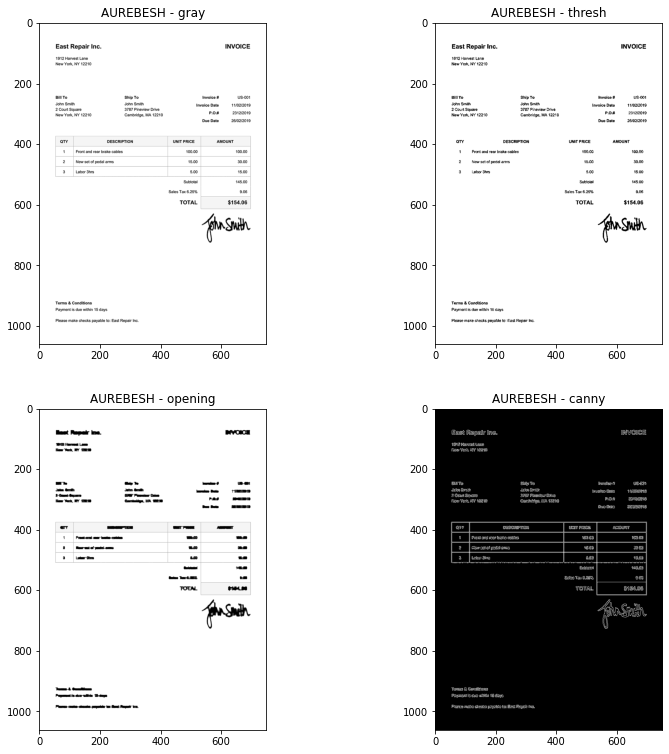

In [16]:
fig = plt.figure(figsize=(13,13))
ax = []

rows = 2
columns = 2
keys = list(images.keys())
for i in range(rows*columns):
    ax.append( fig.add_subplot(rows, columns, i+1) )
    ax[-1].set_title('AUREBESH - ' + keys[i]) 
    plt.imshow(images[keys[i]], cmap='gray') 

## Extract Text 

In [17]:
custom_config = r'--oem 3 --psm 6'
print('-----------------------------------------')
print('TESSERACT OUTPUT --> ORIGINAL IMAGE')
print('-----------------------------------------')
print(pytesseract.image_to_string(image, config=custom_config))
print('\n-----------------------------------------')
print('TESSERACT OUTPUT --> THRESHOLDED IMAGE')
print('-----------------------------------------')
print(pytesseract.image_to_string(image, config=custom_config))
print('\n-----------------------------------------')
print('TESSERACT OUTPUT --> OPENED IMAGE')
print('-----------------------------------------')
print(pytesseract.image_to_string(image, config=custom_config))
print('\n-----------------------------------------')
print('TESSERACT OUTPUT --> CANNY EDGE IMAGE')
print('-----------------------------------------')
print(pytesseract.image_to_string(image, config=custom_config))

-----------------------------------------
TESSERACT OUTPUT --> ORIGINAL IMAGE
-----------------------------------------
East Repair Inc. INVOICE
1912 Hanest Lane
New York, NY 12210
Bill To Ship To Invoice # us.001
John Smith ohn Smith Invoice Date 1102/2019
2 Court Square 3787 Pineview Drive
New York, NY 12210 Cambridge, MA 12210 PO# 231212019
Due Date 26/02/2019
ary DESCRIPTION UNIT PRICE ‘AMOUNT
1 | Front and rear brake cables 100.00 100.00
2 New set of pedal arms 15.00 30.00
3 Labor 3hrs 5.00 415.00
Subtotal 145.00
Sales Tax 6.25% 9.06
TOTAL $154.06
4 g i
Terms & Conditions
Payment is due within 15 days
Please make checks payable to: East Repair Inc.


-----------------------------------------
TESSERACT OUTPUT --> THRESHOLDED IMAGE
-----------------------------------------
East Repair Inc. INVOICE
1912 Hanest Lane
New York, NY 12210
Bill To Ship To Invoice # us.001
John Smith ohn Smith Invoice Date 1102/2019
2 Court Square 3787 Pineview Drive
New York, NY 12210 Cambridge, MA 12210 

## Drawing Bounding Boxes around Text

### Drawing Boxes around each Character
This is done with the function `image_to_boxes()`.

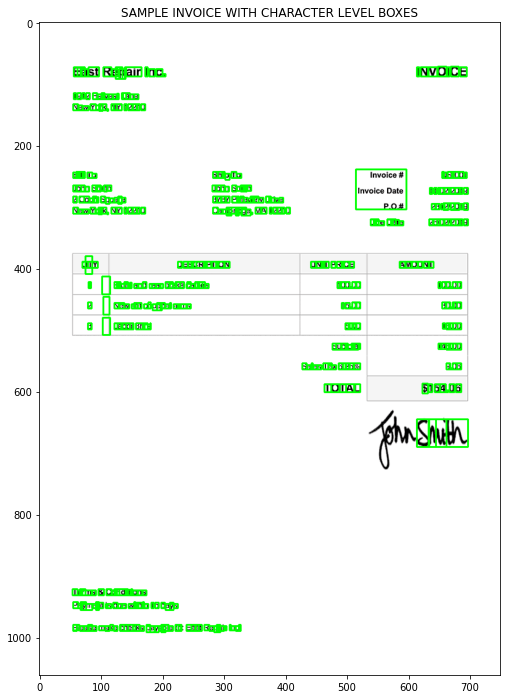

In [18]:
image = cv2.imread('imgs/invoice-input.png')
h, w, c = image.shape
boxes = pytesseract.image_to_boxes(image) 
for b in boxes.splitlines():
    b = b.split(' ')
    image = cv2.rectangle(image, (int(b[1]), h - int(b[2])), (int(b[3]), h - int(b[4])), (0, 255, 0), 2)

b,g,r = cv2.split(image)
rgb_img = cv2.merge([r,g,b])

plt.figure(figsize=(16,12))
plt.imshow(rgb_img)
plt.title('SAMPLE INVOICE WITH CHARACTER LEVEL BOXES')
plt.show()

### Drawing Boxes around each Word
This is done with the function `image_to_data()`.

DATA KEYS: 
 dict_keys(['level', 'page_num', 'block_num', 'par_num', 'line_num', 'word_num', 'left', 'top', 'width', 'height', 'conf', 'text'])


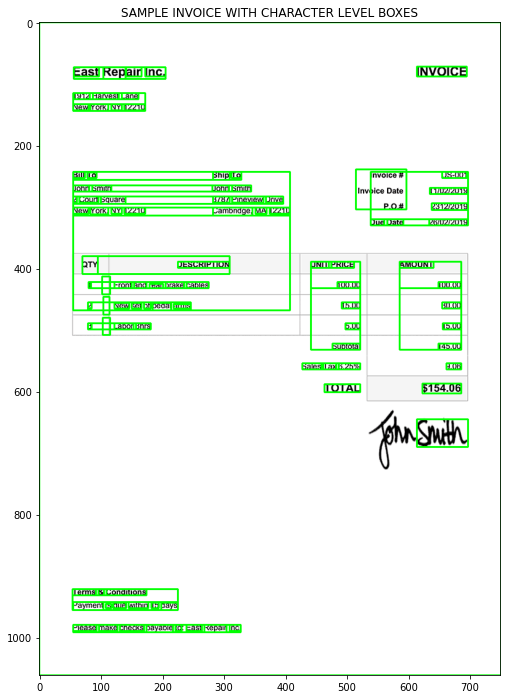

In [26]:
img = cv2.imread('imgs/invoice-input.png')

d = pytesseract.image_to_data(img, output_type=Output.DICT)
print('DATA KEYS: \n', d.keys())

n_boxes = len(d['level'])
for i in range(n_boxes):
    (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
    image = cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

b,g,r = cv2.split(image)
rgb_img = cv2.merge([r,g,b])

plt.figure(figsize=(16,12))
plt.imshow(rgb_img)
plt.title('SAMPLE INVOICE WITH CHARACTER LEVEL BOXES')
plt.show()

## Text template matching

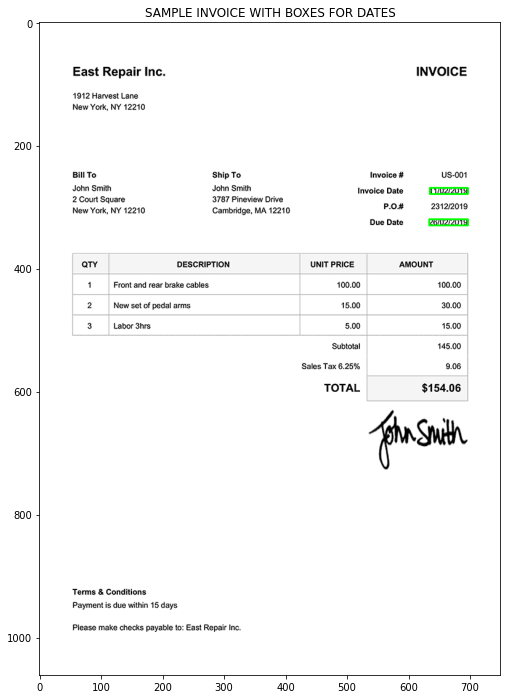

In [29]:
# Plot boxes around text that matches a certain regex template
image = cv2.imread('imgs/invoice-input.png')
date_pattern = '^(0[1-9]|[12][0-9]|3[01])/(0[1-9]|1[012])/(19|20)\d\d$'
    
n_boxes = len(d['level'])
for i in range(n_boxes):
    if re.match(date_pattern, d['text'][i]):
        (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
        image = cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

b,g,r = cv2.split(image)
rgb_img = cv2.merge([r,g,b])
plt.figure(figsize=(16,12))
plt.imshow(rgb_img)
plt.title('SAMPLE INVOICE WITH BOXES FOR DATES')
plt.show()